In [1]:
import os

import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import numpy as np
try:
    import open3d as o3d
except ImportError:
    import sys
    print(sys.exc_info())
import pandas as pd
from scipy import interpolate
import quadpy

from dosipy.utils.dataloader import load_ear_data
from dosipy.utils.integrate import elementwise_quad, elementwise_dblquad
from dosipy.utils.viz import (set_colorblind, scatter_2d, scatter_3d,
                              fig_config)
from helpers import (clean_df, export_pcd, export_fields,
                     poynting_vector, get_imcolors, export_rect_idx)

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [143]:
# set input data

polarization = 'te'
f = 26

if polarization == 'te':
    origin = [-25.28, 17.25]
else:
    origin = [-19.77, 5.22]

if f == 26:
    edge_length = 20
else:
    edge_length = 10

In [144]:
# load surface data

df = load_ear_data(polarization, f, surface='front')
df = clean_df(df)
xyz = export_pcd(df)
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(xyz)
center = pcd.get_center()
cframe = o3d.geometry.TriangleMesh.create_coordinate_frame(
    size=9, origin=center+np.array([6, -25, -20])
)
#o3d.visualization.draw_geometries([pcd, cframe])

In [145]:
# postprocessing on the surface of the model

E, H = export_fields(df)
Sx, Sy, Sz = poynting_vector(E, H)

APD = np.sqrt(np.real(Sx) ** 2 + np.real(Sy) ** 2 + np.real(Sz) ** 2)

In [146]:
# extract points visible from the plane wave incidence POV (-x direction)

diameter = np.linalg.norm(
    pcd.get_max_bound() - pcd.get_min_bound()
)
radius = 10 ** 5
camera = [center[0] + diameter, center[1] * 2.5, center[2]]
_, mask = pcd.hidden_point_removal(camera, radius)
xyz_zy = xyz[mask]
APD_zy = APD[mask]

In [147]:
# compute averaged APD

avg_center = [origin[0]+edge_length/2,
              origin[1]+edge_length/2]
area = edge_length ** 2
pAPD_origin, idx_rect = export_rect_idx(xyz=xyz_zy,
                                        center=avg_center,
                                        edge_length=edge_length,
                                        view='zy')
xyz_rect = xyz_zy[idx_rect]

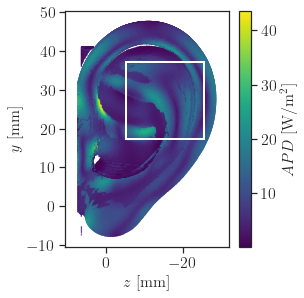

In [148]:
set_colorblind()
label = '$APD$ [W/m$^2$]'
fig_config(latex=True, scaler=1.5, text_size=16)
fig, ax = scatter_2d({'$z$ [mm]': xyz_zy[:, 2],
                      '$y$ [mm]': xyz_zy[:, 1],
                      label: APD_zy}, s=0.1, figsize=(2.950 * 1.5, 2.950 * 1.5))
patch_rect = Rectangle(pAPD_origin, edge_length, edge_length, fc='None', lw=2)
ax.add_patch(patch_rect)
ax.invert_xaxis()

In [149]:
pcd_rect = o3d.geometry.PointCloud()
pcd_rect.points = o3d.utility.Vector3dVector(xyz_rect)
pcd_rect.estimate_normals(search_param=o3d.geometry.KDTreeSearchParamKNN(1000))
pcd_rect.orient_normals_consistent_tangent_plane(1000)
n = np.asarray(pcd_rect.normals)

APD_rect = (Sx[mask][idx_rect].real * n[:, 0]
            + Sy[mask][idx_rect].real * n[:, 1]
            + Sz[mask][idx_rect].real * n[:, 2])

In [150]:
o3d.visualization.draw_geometries([pcd_rect], point_show_normal=True)

In [151]:
degree = 21
points = np.c_[xyz_rect[:, 2], xyz_rect[:, 1]]
bbox = [origin[0], origin[0]+edge_length, origin[1], origin[1]+edge_length]

In [152]:
func = interpolate.SmoothBivariateSpline(points[:, 0], points[:, 1], APD_rect, bbox=bbox, kx=3, ky=3)

scheme = quadpy.c2.get_good_scheme(degree)
val = scheme.integrate(lambda x: func(x[0], x[1], grid=False),
                       quadpy.c2.rectangle_points([origin[0], origin[0]+edge_length],
                                                  [origin[1], origin[1]+edge_length]))
APD_av = val / area
APD_av

-5.776739590719884

In [138]:
func = interpolate.CloughTocher2DInterpolator(points, APD_rect, fill_value=0)

scheme = quadpy.c2.get_good_scheme(degree)
val = scheme.integrate(lambda x: func(x[0], x[1]),
                       quadpy.c2.rectangle_points([origin[0], origin[0]+edge_length],
                                                  [origin[1], origin[1]+edge_length]))
APD_av = val / area
APD_av

-5.371399780281487

In [110]:
func = interpolate.NearestNDInterpolator(points, APD_rect)

scheme = quadpy.c2.get_good_scheme(degree)
val = scheme.integrate(lambda x: func(x[0], x[1]),
                       quadpy.c2.rectangle_points([origin[0], origin[0]+edge_length],
                                                  [origin[1], origin[1]+edge_length]))
APD_av = val / area
APD_av

5.277102946794816

In [105]:
func = interpolate.LinearNDInterpolator(points, APD_rect, fill_value=0)

scheme = quadpy.c2.get_good_scheme(degree)
val = scheme.integrate(lambda x: func(x[0], x[1]),
                       quadpy.c2.rectangle_points([origin[0], origin[0]+edge_length],
                                                  [origin[1], origin[1]+edge_length]))
APD_av = val / area
APD_av

5.325379817331344